In [1]:
import os
import gc
import sys

import random
import numpy as np
import pandas as pd
import seaborn as sns

from tqdm.notebook import *
import matplotlib.pyplot as plt

import warnings
tqdm_notebook().pandas()

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 500)
warnings.simplefilter("ignore")

0it [00:00, ?it/s]

In [2]:
train_data_path  = "/kaggle/input/datachallenge/train_set.csv"
test_data_path  = "/kaggle/input/datachallenge/test_set.csv"

In [3]:
df_trains = pd.read_csv(train_data_path)
df_tests = pd.read_csv(test_data_path)

In [4]:
drop_col = ["Vanne_position_1","Vanne_position_2"]
df_train = df_trains.drop(drop_col, axis= 1)
df_test  = df_tests.drop(drop_col, axis= 1)

In [5]:
df_train["scope"] = "train"
df_test["scope"] = "test"
df = pd.concat([df_train,df_test],axis=0)
#df['date'] = pd.to_datetime(df['date'])


In [152]:
#df = df.reset_index('date')


# Start

import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt


df_s= df.drop(columns=["Wind_turbine_name","scope", "Power"])
for col in df_s.columns:
    df_s[col] =  pd.to_numeric(df_s[col], errors='coerce').astype('float16')

df_s

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.neural_network import MLPRegressor

imputer = IterativeImputer(estimator=MLPRegressor(), max_iter=3, random_state=0)

df_less = df_s[["Generator_converter_speed","Generator_temp_1", "Nacelle_temperature"]]

for col in tqdm(df_s.columns):
    imputer = IterativeImputer(estimator=MLPRegressor(), max_iter=10, random_state=0)
    df_s[col] = pd.DataFrame(imputer.fit_transform(df_s[[col]]), columns=df_s[[col]].columns, index=df_s[[col]].index)


for col in df.columns:
    try:
        df[col] = df_s[col]
    except: pass

df.isna().sum()

In [49]:
#df_imputed = pd.DataFrame(imputer.fit_transform(df_less), columns=df_less.columns, index=df_less.index)


df_imputed

"""
df_imputed = pd.DataFrame(imputer.fit_transform(df_s), columns=df_s.columns, index=df_s.index)

print(df_imputed)
"""

df_train.isna().sum()

# END

In [7]:
from numba import jit, prange
from sklearn.impute import KNNImputer
from sklearn.pipeline import make_union
from sklearn.impute import MissingIndicator

@jit
def knn_imputer(df, columns, n_neig=4):
    imputer = KNNImputer(n_neighbors=n_neig)
    pipeline = make_union(KNNImputer(n_neighbors=n_neig),
                     MissingIndicator())

    df_filled = pipeline.fit_transform(df[[columns]])
    return df_filled


In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

In [9]:
@jit
def fill_na(df, columns):
    for col in tqdm(columns):
        df[col] =  pd.to_numeric(df[col].values, errors='coerce').astype('float32')
        scaler = StandardScaler()
        #df[col] = scaler.fit_transform(df[col].fillna(df[col].median()))
        df[col] = scaler.fit_transform(knn_imputer(df, col))
    return df



In [10]:
col_fill_na = ['Pitch_angle','Hub_temperature', 'Generator_converter_speed', 'Generator_temp_1',
               'Generator_temp_2', 'Nacelle_angle','Wind_direction', 'Outdoor_temp', 'Outdoor_temp_min','Outdoor_temp_min',
               'Outdoor_temp_max','Grid_frequency','Grid_voltage','Rotor_temp','wind_direction_corrected']
df_fill = fill_na(df, col_fill_na)

  0%|          | 0/15 [00:00<?, ?it/s]

In [11]:
from sklearn.preprocessing import LabelEncoder


cols_with_na = ["date", "Wind_turbine_name"]
for c in cols_with_na:
    mode_ = df[c].value_counts().index[0]
    df.loc[df[c].isna(),c] = mode_
enc = LabelEncoder()
df["Wind_turbine_name_enc"] = enc.fit_transform(df["Wind_turbine_name"])


In [12]:
import pandas as pd
import numpy as np
from scipy import signal

def create_features(df, groupby_cols=None):
 
    if groupby_cols is not None:
        grouped = df.groupby(groupby_cols)
    else:
        grouped = [df]

    dfs = []
    for name, group in grouped:

        lags = [1, 2, 3, 4, 5]
        for col in ['Pitch_angle', 'Hub_temperature', 'Generator_converter_speed']:
            for lag in lags:
                group[f'{col}_lag_{lag}'] = group[col].shift(lag)
        
        windows = [2, 5, 10]
        for col in ['Pitch_angle', 'Hub_temperature', 'Generator_converter_speed']:
            for window in windows:
                group[f'{col}_rolling_mean_{window}'] = group[col].rolling(window).mean()

        for col in ['Generator_temp_1', 'Generator_temp_2']:
            freqs, psd = signal.welch(group[col])
            laplace = np.trapz(np.log(psd[:10]), freqs[:10])
            group[f'{col}_laplace_transform'] = laplace

        dfs.append(group)

    return pd.concat(dfs)


groupby_cols = ['Wind_turbine_name']

new_df = create_features(df, groupby_cols)


In [13]:
new_df

,Wind_turbine_name,Pitch_angle,Hub_temperature,Generator_converter_speed,Power,Generator_temp_1,Generator_temp_2,Nacelle_angle,Nacelle_temperature,Wind_direction,Outdoor_temp,Outdoor_temp_min,Outdoor_temp_max,Grid_frequency,Grid_voltage,Rotor_temp,wind_direction_corrected,date,scope,Wind_turbine_name_enc,Pitch_angle_lag_1,Pitch_angle_lag_2,Pitch_angle_lag_3,Pitch_angle_lag_4,Pitch_angle_lag_5,Hub_temperature_lag_1,Hub_temperature_lag_2,Hub_temperature_lag_3,Hub_temperature_lag_4,Hub_temperature_lag_5,Generator_converter_speed_lag_1,Generator_converter_speed_lag_2,Generator_converter_speed_lag_3,Generator_converter_speed_lag_4,Generator_converter_speed_lag_5,Pitch_angle_rolling_mean_2,Pitch_angle_rolling_mean_5,Pitch_angle_rolling_mean_10,Hub_temperature_rolling_mean_2,Hub_temperature_rolling_mean_5,Hub_temperature_rolling_mean_10,Generator_converter_speed_rolling_mean_2,Generator_converter_speed_rolling_mean_5,Generator_converter_speed_rolling_mean_10,Generator_temp_1_laplace_transform,Generator_temp_2_laplace_transform
0,R80711,-0.543596,-1.077654,-0.984032,1177.314967,-0.097150,0.382179,-0.140868,17.480000,-0.106140,-0.844340,-0.841079,-0.843493,0.013924,1.803602,0.242211,0.117047,2012-12-31 23:00:00+01:00,train,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.068908,0.060143
1,R80711,-0.543784,-1.118866,-0.967054,1200.676667,-0.438457,0.250170,-0.042433,17.075000,-0.089661,-0.811980,-0.815182,-0.826500,0.057049,1.781599,0.203957,0.135241,2013-01-01 00:00:00+01:00,train,0,-0.543596,NaN,NaN,NaN,NaN,-1.077654,NaN,NaN,NaN,NaN,-0.984032,NaN,NaN,NaN,NaN,-0.543690,NaN,NaN,-1.098260,NaN,NaN,-0.975543,NaN,NaN,0.068908,0.060143
2,R80711,-0.543784,-1.154994,-0.769609,1092.826665,-0.403630,0.303675,-0.042433,17.175000,-0.006354,-0.798694,-0.795759,-0.803134,0.066637,2.041837,0.185767,0.227222,2013-01-01 01:00:00+01:00,train,0,-0.543784,-0.543596,NaN,NaN,NaN,-1.118866,-1.077654,NaN,NaN,NaN,-0.967054,-0.984032,NaN,NaN,NaN,-0.543784,NaN,NaN,-1.136930,NaN,NaN,-0.868331,NaN,NaN,0.068908,0.060143
3,R80711,-0.542908,-1.167840,-0.731682,1080.954980,-0.037508,0.433814,-0.042433,16.761666,-0.023346,-0.871770,-0.871292,-0.868982,0.057060,1.014194,0.203423,0.208461,2013-01-01 02:00:00+01:00,train,0,-0.543784,-0.543784,-0.543596,NaN,NaN,-1.154994,-1.118866,-1.077654,NaN,NaN,-0.769609,-0.967054,-0.984032,NaN,NaN,-0.543346,NaN,NaN,-1.161417,NaN,NaN,-0.750645,NaN,NaN,0.068908,0.060143
4,R80711,-0.533018,-1.128768,-0.824860,1351.328317,-0.507241,0.184517,-0.064324,14.630000,-0.118133,-0.958776,-0.955456,-0.966692,0.047471,1.450734,0.134638,0.103805,2013-01-01 03:00:00+01:00,train,0,-0.542908,-0.543784,-0.543784,-0.543596,NaN,-1.167840,-1.154994,-1.118866,-1.077654,NaN,-0.731682,-0.769609,-0.967054,-0.984032,NaN,-0.537963,-0.541418,NaN,-1.148304,-1.129625,NaN,-0.778271,-0.855447,NaN,0.068908,0.060143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52727,R80790,0.206735,-0.860886,2.265808,NaN,0.581982,0.274002,-1.499495,27.841667,-1.517630,-0.809195,-0.813024,-0.805258,0.057060,0.446378,-0.336403,-0.057217,2018-1-12T19:00+01:00,test,3,-0.543909,-0.543784,-0.542908,0.386933,1.183205,-0.860886,-0.860886,-0.860886,-0.860886,-0.808701,-0.512502,-0.497066,-0.805614,0.058602,-0.926229,-0.168587,-0.207386,0.026438,-0.860886,-0.860886,-0.805034,0.876653,0.101846,0.173289,0.067040,0.066302
52728,R80790,-0.542720,-0.860886,-0.566966,NaN,0.281379,0.006014,-1.499495,20.725000,-1.493435,-0.912273,-0.915532,-0.909341,0.018718,0.246020,-0.404081,-0.057217,2018-1-12T20:00+01:00,test,3,0.206735,-0.543909,-0.543784,-0.542908,0.386933,-0.860886,-0.860886,-0.860886,-0.860886,-0.860886,2.265808,-0.512502,-0.497066,-0.805614,0.058602,-0.167992,-0.393317,-0.036909,-0.860886,-0.860886,-0.821118,0.849421,-0.023268,0.111110,0.067040,0.066302
52729,R80790,-0.541030,-0.860886,-0.629179,NaN,-0.3

In [14]:
for col in tqdm(new_df.columns):
    if new_df[col].isna().sum() > 0 and col != 'Power':
        fill_na(new_df, [col])
    else:
        print(col)
        

  0%|          | 0/46 [00:00<?, ?it/s]

Wind_turbine_name
Pitch_angle
Hub_temperature
Generator_converter_speed
Power
Generator_temp_1
Generator_temp_2
Nacelle_angle
Nacelle_temperature
Wind_direction
Outdoor_temp
Outdoor_temp_min
Outdoor_temp_max
Grid_frequency
Grid_voltage
Rotor_temp
wind_direction_corrected
date
scope
Wind_turbine_name_enc


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Generator_temp_1_laplace_transform
Generator_temp_2_laplace_transform


In [15]:
new_df.isna().sum()

Wind_turbine_name                                0
Pitch_angle                                      0
Hub_temperature                                  0
Generator_converter_speed                        0
Power                                        52732
Generator_temp_1                                 0
Generator_temp_2                                 0
Nacelle_angle                                    0
Nacelle_temperature                              0
Wind_direction                                   0
Outdoor_temp                                     0
Outdoor_temp_min                                 0
Outdoor_temp_max                                 0
Grid_frequency                                   0
Grid_voltage                                     0
Rotor_temp                                       0
wind_direction_corrected                         0
date                                             0
scope                                            0
Wind_turbine_name_enc          

In [ ]:
"""scaler = StandardScaler()
X_scalled = scaler.fit_transform(knn_imputer(df, col))
X_poly = PolynomialFeatures().fit_transform(X_scalled)"""

In [75]:
df = new_df.reset_index()


In [113]:
df = df.set_index('date')

# create a new DataFrame with a complete set of dates
date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
df_dates = pd.DataFrame(index=date_range)

# merge the new DataFrame with the original DataFrame
df_merged = pd.merge(df_dates, df, left_index=True, right_index=True, how='outer')

# fill missing values using forward fill
df_filled = df_merged.fillna(method='ffill')
df_filled["date"] = df_filled["index"]

df_filled = df_filled.drop(columns = "index")

In [114]:
df_filled = df_filled.reset_index()


In [125]:
df = df_filled

In [124]:
mi = MissingIndicator()

In [104]:
mi.fit(df[["date"]])

MissingIndicator()

In [106]:
cs = mi.transform(df[["date"]])

In [158]:
df

,date,Wind_turbine_name,Pitch_angle,Hub_temperature,Generator_converter_speed,Power,Generator_temp_1,Generator_temp_2,Nacelle_angle,Nacelle_temperature,Wind_direction,Outdoor_temp,Outdoor_temp_min,Outdoor_temp_max,Grid_frequency,Grid_voltage,Rotor_temp,wind_direction_corrected,scope,Wind_turbine_name_enc
0,2012-12-31 23:00:00+01:00,R80711,-0.543596,-1.077654,-0.984032,1177.314967,-0.097150,0.382179,-0.140868,17.480000,-0.106140,-0.844340,-0.841079,-0.843493,0.013924,1.803602,0.242211,0.117047,train,0
1,2013-01-01 00:00:00+01:00,R80711,-0.543784,-1.118866,-0.967054,1200.676667,-0.438457,0.250170,-0.042433,17.075000,-0.089661,-0.811980,-0.815182,-0.826500,0.057049,1.781599,0.203957,0.135241,train,0
2,2013-01-01 01:00:00+01:00,R80711,-0.543784,-1.154994,-0.769609,1092.826665,-0.403630,0.303675,-0.042433,17.175000,-0.006354,-0.798694,-0.795759,-0.803134,0.066637,2.041837,0.185767,0.227222,train,0
3,2013-01-01 02:00:00+01:00,R80711,-0.542908,-1.167840,-0.731682,1080.954980,-0.037508,0.433814,-0.042433,16.761666,-0.023346,-0.871770,-0.871292,-0.868982,0.057060,1.014194,0.203423,0.208461,train,0
4,2013-01-01 03:00:00+01:00,R80711,-0.533018,-1.128768,-0.824860,1351.328317,-0.507241,0.184517,-0.064324,14.630000,-0.118133,-0.958776,-0.955456,-0.966692,0.047471,1.450734,0.134638,0.103805,train,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176247,2018-01-12 19:00:00+01:00,R80790,0.206735,-0.860886,2.265808,NaN,0.581982,0.274002,-1.499495,27.841667,-1.517630,-0.809195,-0.813024,-0.805258,0.057060,0.446378,-0.336403,-0.057217,test,3
176248,2018-01-12 20:00:00+01:00,R80790,-0.542720,-0.860886,-0.566966,NaN,0.281379,0.006014,-1.499495,20.725000,-1.493435,-0.912273,-0.915532,-0.909341,0.018718,0.246020,-0.404081,-0.057217,test,3
176249,2018-01-12 21:00:00+01:00,R80790,-0.541030,-0.860886,-0.629179,NaN,-0.352695,-0.380900,-1.272512,23.783333,-1.346777,-0.939918,-0.936034,-0.939078,0.047471,0.525196,-0.393114,-0.057217,test,3
176250,2018-01-12 22:00:00+01:00,R80790,-0.345811,-0.860886,0.465588,NaN,0.302928,0.052508,-1.246784,22.385000,-1.140403,-1.094213,-1.101126,-0.897543,0.100195,0.623711,-0.339613,-0.057217,test,3


In [ ]:
df = new_df.copy()

In [16]:
df['date'] = pd.to_datetime(df['date'])
df["year"] = df["date"].dt.year.astype(np.int32)
df["month"] = df["date"].dt.month.astype(np.int32)
df["week"] = df["date"].dt.week.astype(np.int32)
df["day"] = df["date"].dt.day.astype(np.int32)
df["dayofyear"] = df["date"].dt.dayofyear.astype(np.int32)
df['is_month_start'] = (df.date.dt.is_month_start).astype(int)
df['is_month_end'] = (df.date.dt.is_month_end).astype(int)

df["is_wknd"] = df.date.dt.weekday // 4
df["quarter"] = df.date.dt.quarter
df['is_month_start'] = df.date.dt.is_month_start.astype(int)
df['is_month_end'] = df.date.dt.is_month_end.astype(int)
df['is_quarter_start'] = df.date.dt.is_quarter_start.astype(int)
df['is_quarter_end'] = df.date.dt.is_quarter_end.astype(int)
df['is_year_start'] = df.date.dt.is_year_start.astype(int)
df['is_year_end'] = df.date.dt.is_year_end.astype(int)

# 0: Winter - 1: Spring - 2: Summer - 3: Fall
df["season"] = np.where(df.month.isin([12,1,2]), 0, 1)
df["season"] = np.where(df.month.isin([6,7,8]), 2, df["season"])
df["season"] = np.where(df.month.isin([9, 10, 11]), 3, df["season"])
#df = df.drop(columns=['date','Wind_turbine_name'])

In [17]:
df = df.drop(columns=["date", "Wind_turbine_name"])

In [ ]:
from sklearn.decomposition import PCA

def apply_pca(df, pca, status= True):
    if not status:
        pca.fit(df)
        print("n_components_ = ", pca.n_components_)
    df_transformed = pca.transform(df)
    columns = ['pca_{}'.format(i+1) for i in range(pca.n_components_)]
    df_pca = pd.DataFrame(df_transformed, columns=columns)
    return df_pca


In [18]:
df_train = df[df.scope=='train'].reset_index(drop=True)
df_test = df[df.scope=='test'].reset_index(drop=True)
df_train = df_train.drop(columns="scope")
df_test = df_test.drop(columns="scope")
df_test = df_test.drop(columns="Power")

In [ ]:
#pca = PCA(n_components=0.999)
#df_trains = apply_pca(df_train.drop(columns="Power"), pca, status=False)
#df_tests = apply_pca(df_test, pca, status=True)

In [ ]:
#df_trains.shape, df_train.shape

### Modelisation

In [162]:
params = {
    'objective':"mean_absolute_percentage_error",
    'bagging_freq': 1,
    'bagging_fraction': 0.9,
    'boost_from_average':'true',
    'boosting_type': 'gbdt',
    "num_threads":4,
    'min_data_in_leaf':128,
    "num_leaves":3200,
    'feature_fraction': 0.9,
    'learning_rate': 0.0082,
    'verbosity': -1,
}

In [130]:
def lgbm_features_importance(clf,features,n=15,size=(15,12)):
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df=fold_importance_df.sort_values("importance",ascending=False).iloc[:n,:]
    plt.figure(figsize=size)
    sns.barplot(x="importance", y="Feature", data=fold_importance_df) 
    plt.title('Features importance ')
    plt.tight_layout()
    plt.show()

TRAINING IN FOLD :  0
[1]	valid_0's mape: 0.843168
Training until validation scores don't improve for 200 rounds
[2]	valid_0's mape: 0.837458
[3]	valid_0's mape: 0.831813
[4]	valid_0's mape: 0.825921
[5]	valid_0's mape: 0.821002
[6]	valid_0's mape: 0.815287
[7]	valid_0's mape: 0.810209
[8]	valid_0's mape: 0.80502
[9]	valid_0's mape: 0.799853
[10]	valid_0's mape: 0.794565
[11]	valid_0's mape: 0.789567
[12]	valid_0's mape: 0.78444
[13]	valid_0's mape: 0.779736
[14]	valid_0's mape: 0.774775
[15]	valid_0's mape: 0.769989
[16]	valid_0's mape: 0.765258
[17]	valid_0's mape: 0.760582
[18]	valid_0's mape: 0.755687
[19]	valid_0's mape: 0.751021
[20]	valid_0's mape: 0.746513
[21]	valid_0's mape: 0.742041
[22]	valid_0's mape: 0.73782
[23]	valid_0's mape: 0.733507
[24]	valid_0's mape: 0.729031
[25]	valid_0's mape: 0.724694
[26]	valid_0's mape: 0.720506
[27]	valid_0's mape: 0.716249
[28]	valid_0's mape: 0.712047
[29]	valid_0's mape: 0.707762
[30]	valid_0's mape: 0.703636
[31]	valid_0's mape: 0.69930

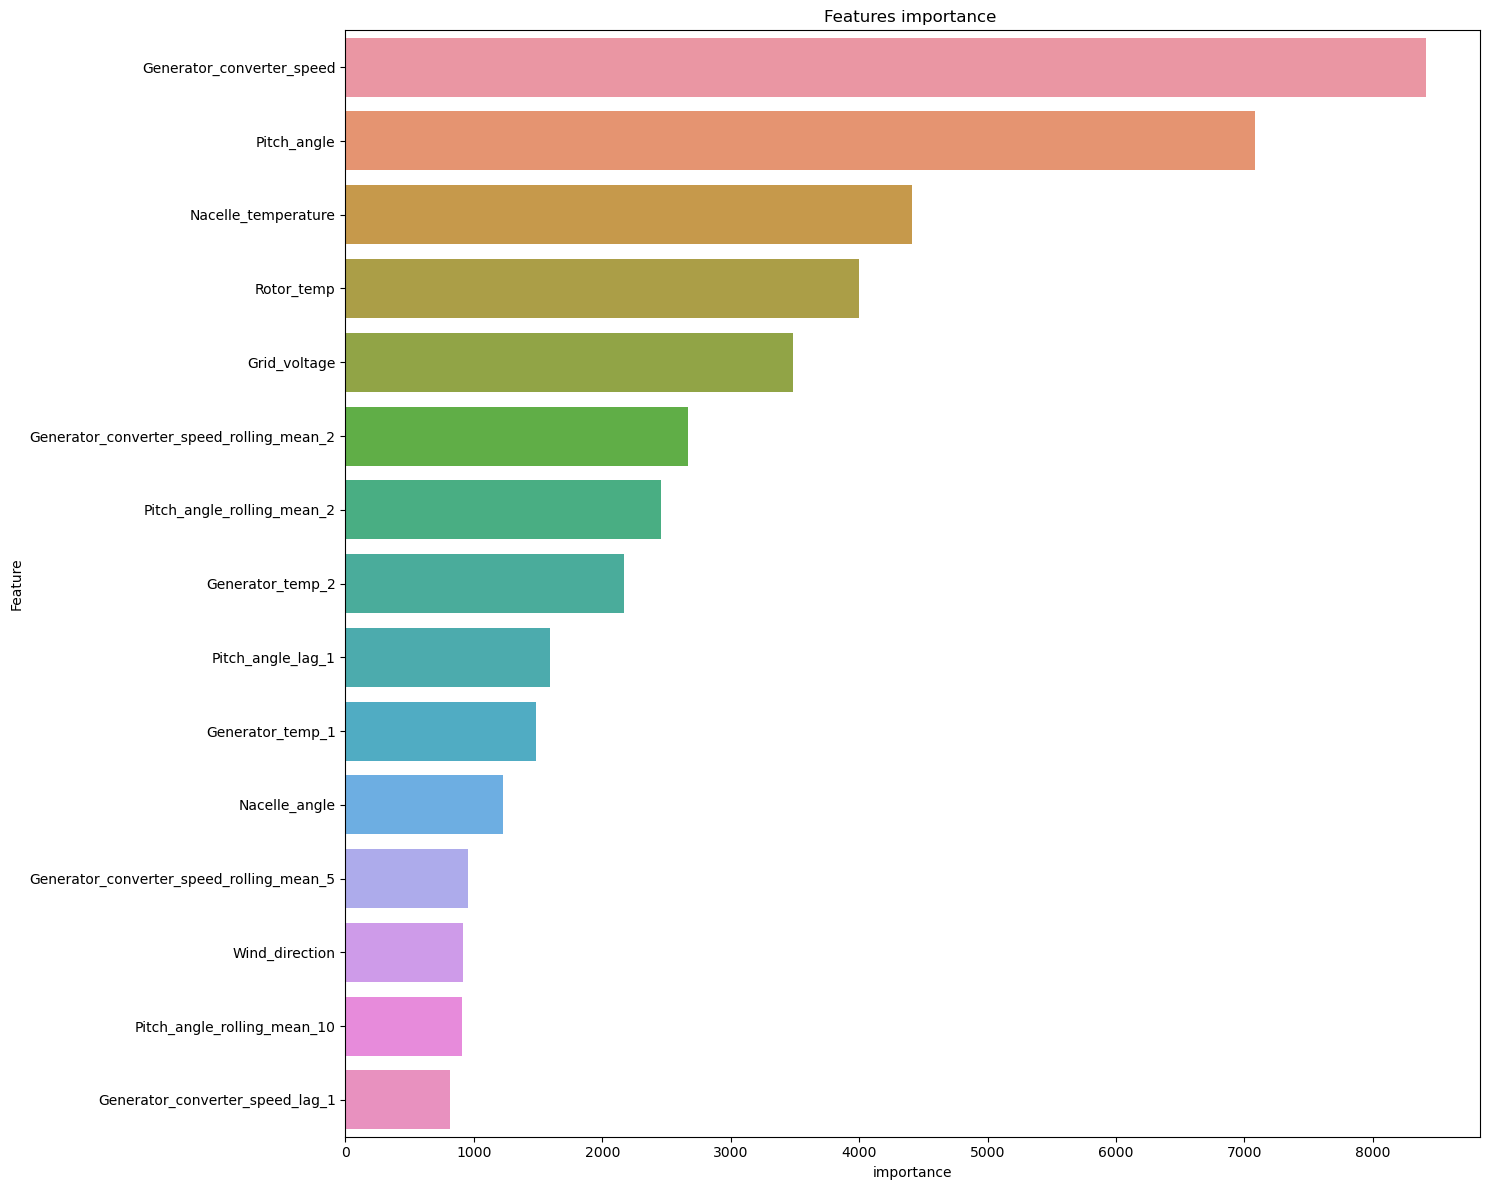

 MAE Val score = 160.6106
 MEDIAN AE Val score = 43.9474
 r2_score Val score =  0.2938
TRAINING IN FOLD :  1
[1]	valid_0's mape: 0.90068
Training until validation scores don't improve for 200 rounds
[2]	valid_0's mape: 0.894958
[3]	valid_0's mape: 0.889105
[4]	valid_0's mape: 0.883409
[5]	valid_0's mape: 0.877949
[6]	valid_0's mape: 0.872213
[7]	valid_0's mape: 0.866741
[8]	valid_0's mape: 0.861251
[9]	valid_0's mape: 0.855694
[10]	valid_0's mape: 0.850376
[11]	valid_0's mape: 0.844913
[12]	valid_0's mape: 0.839816
[13]	valid_0's mape: 0.834741
[14]	valid_0's mape: 0.829604
[15]	valid_0's mape: 0.824356
[16]	valid_0's mape: 0.819223
[17]	valid_0's mape: 0.814085
[18]	valid_0's mape: 0.809199
[19]	valid_0's mape: 0.804258
[20]	valid_0's mape: 0.7995
[21]	valid_0's mape: 0.794779
[22]	valid_0's mape: 0.790088
[23]	valid_0's mape: 0.785426
[24]	valid_0's mape: 0.780707
[25]	valid_0's mape: 0.776061
[26]	valid_0's mape: 0.771457
[27]	valid_0's mape: 0.766967
[28]	valid_0's mape: 0.762485
[

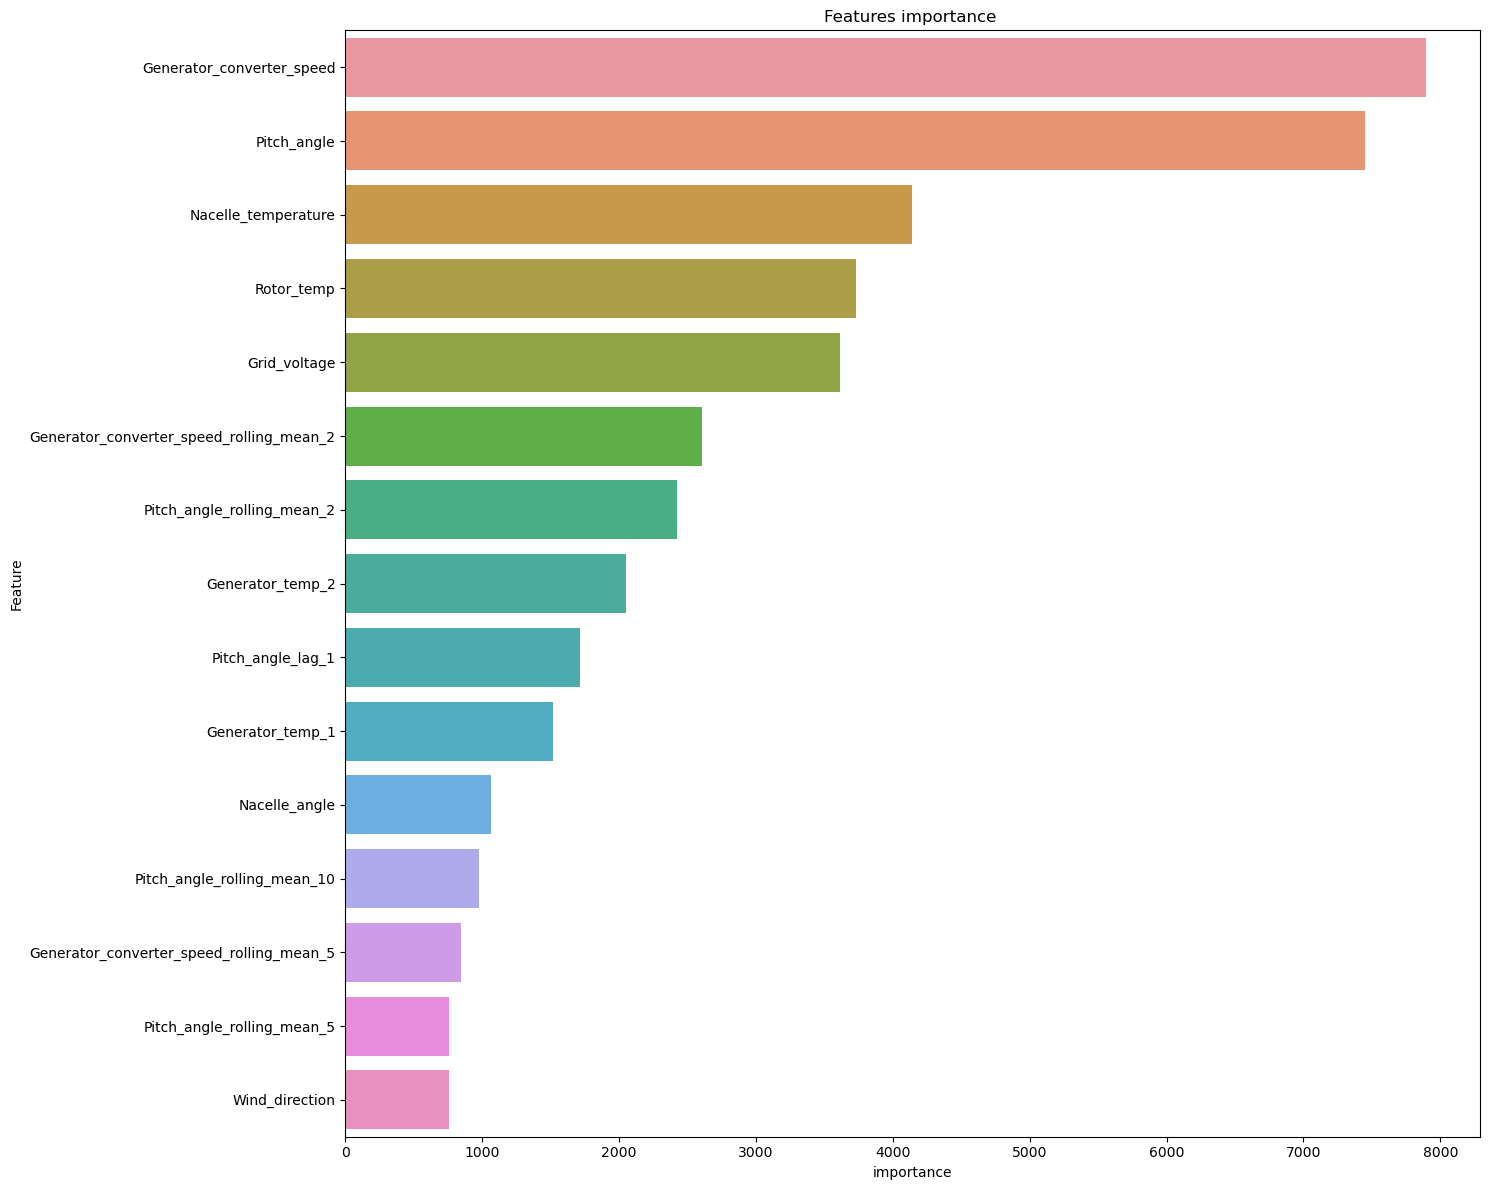

 MAE Val score = 248.0012
 MEDIAN AE Val score = 106.2084
 r2_score Val score =  0.1635
TRAINING IN FOLD :  2
[1]	valid_0's mape: 0.906649
Training until validation scores don't improve for 200 rounds
[2]	valid_0's mape: 0.899827
[3]	valid_0's mape: 0.892999
[4]	valid_0's mape: 0.886346
[5]	valid_0's mape: 0.879816
[6]	valid_0's mape: 0.873184
[7]	valid_0's mape: 0.866555
[8]	valid_0's mape: 0.860059
[9]	valid_0's mape: 0.853528
[10]	valid_0's mape: 0.847019
[11]	valid_0's mape: 0.840647
[12]	valid_0's mape: 0.834338
[13]	valid_0's mape: 0.828047
[14]	valid_0's mape: 0.821844
[15]	valid_0's mape: 0.815792
[16]	valid_0's mape: 0.809643
[17]	valid_0's mape: 0.803529
[18]	valid_0's mape: 0.797579
[19]	valid_0's mape: 0.791659
[20]	valid_0's mape: 0.785943
[21]	valid_0's mape: 0.780172
[22]	valid_0's mape: 0.774574
[23]	valid_0's mape: 0.769037
[24]	valid_0's mape: 0.763441
[25]	valid_0's mape: 0.757948
[26]	valid_0's mape: 0.752399
[27]	valid_0's mape: 0.747039
[28]	valid_0's mape: 0.7416

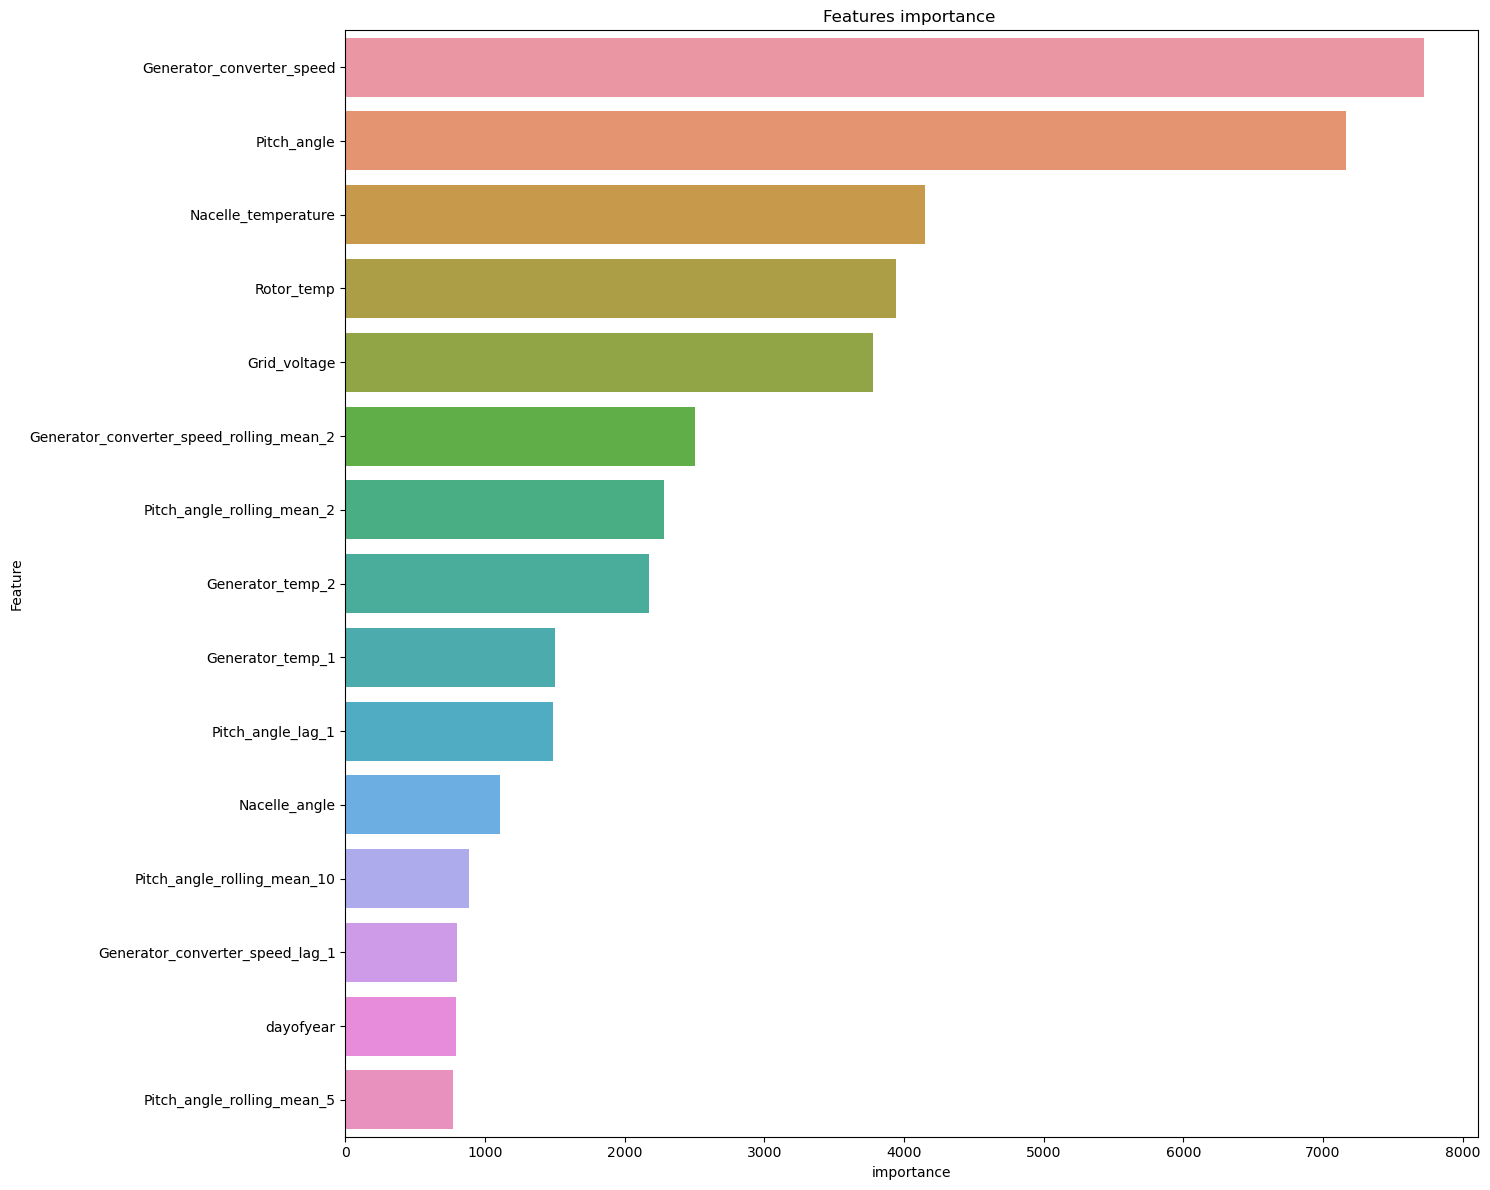

 MAE Val score = 192.1991
 MEDIAN AE Val score = 64.5780
 r2_score Val score =  0.3428
TRAINING IN FOLD :  3
[1]	valid_0's mape: 0.920777
Training until validation scores don't improve for 200 rounds
[2]	valid_0's mape: 0.914233
[3]	valid_0's mape: 0.907865
[4]	valid_0's mape: 0.901528
[5]	valid_0's mape: 0.895727
[6]	valid_0's mape: 0.889548
[7]	valid_0's mape: 0.883479
[8]	valid_0's mape: 0.877381
[9]	valid_0's mape: 0.871286
[10]	valid_0's mape: 0.865469
[11]	valid_0's mape: 0.859647
[12]	valid_0's mape: 0.853878
[13]	valid_0's mape: 0.84834
[14]	valid_0's mape: 0.842701
[15]	valid_0's mape: 0.837085
[16]	valid_0's mape: 0.831402
[17]	valid_0's mape: 0.825847
[18]	valid_0's mape: 0.820386
[19]	valid_0's mape: 0.815003
[20]	valid_0's mape: 0.809951
[21]	valid_0's mape: 0.804737
[22]	valid_0's mape: 0.799462
[23]	valid_0's mape: 0.794025
[24]	valid_0's mape: 0.788873
[25]	valid_0's mape: 0.783732
[26]	valid_0's mape: 0.778786
[27]	valid_0's mape: 0.773806
[28]	valid_0's mape: 0.768915

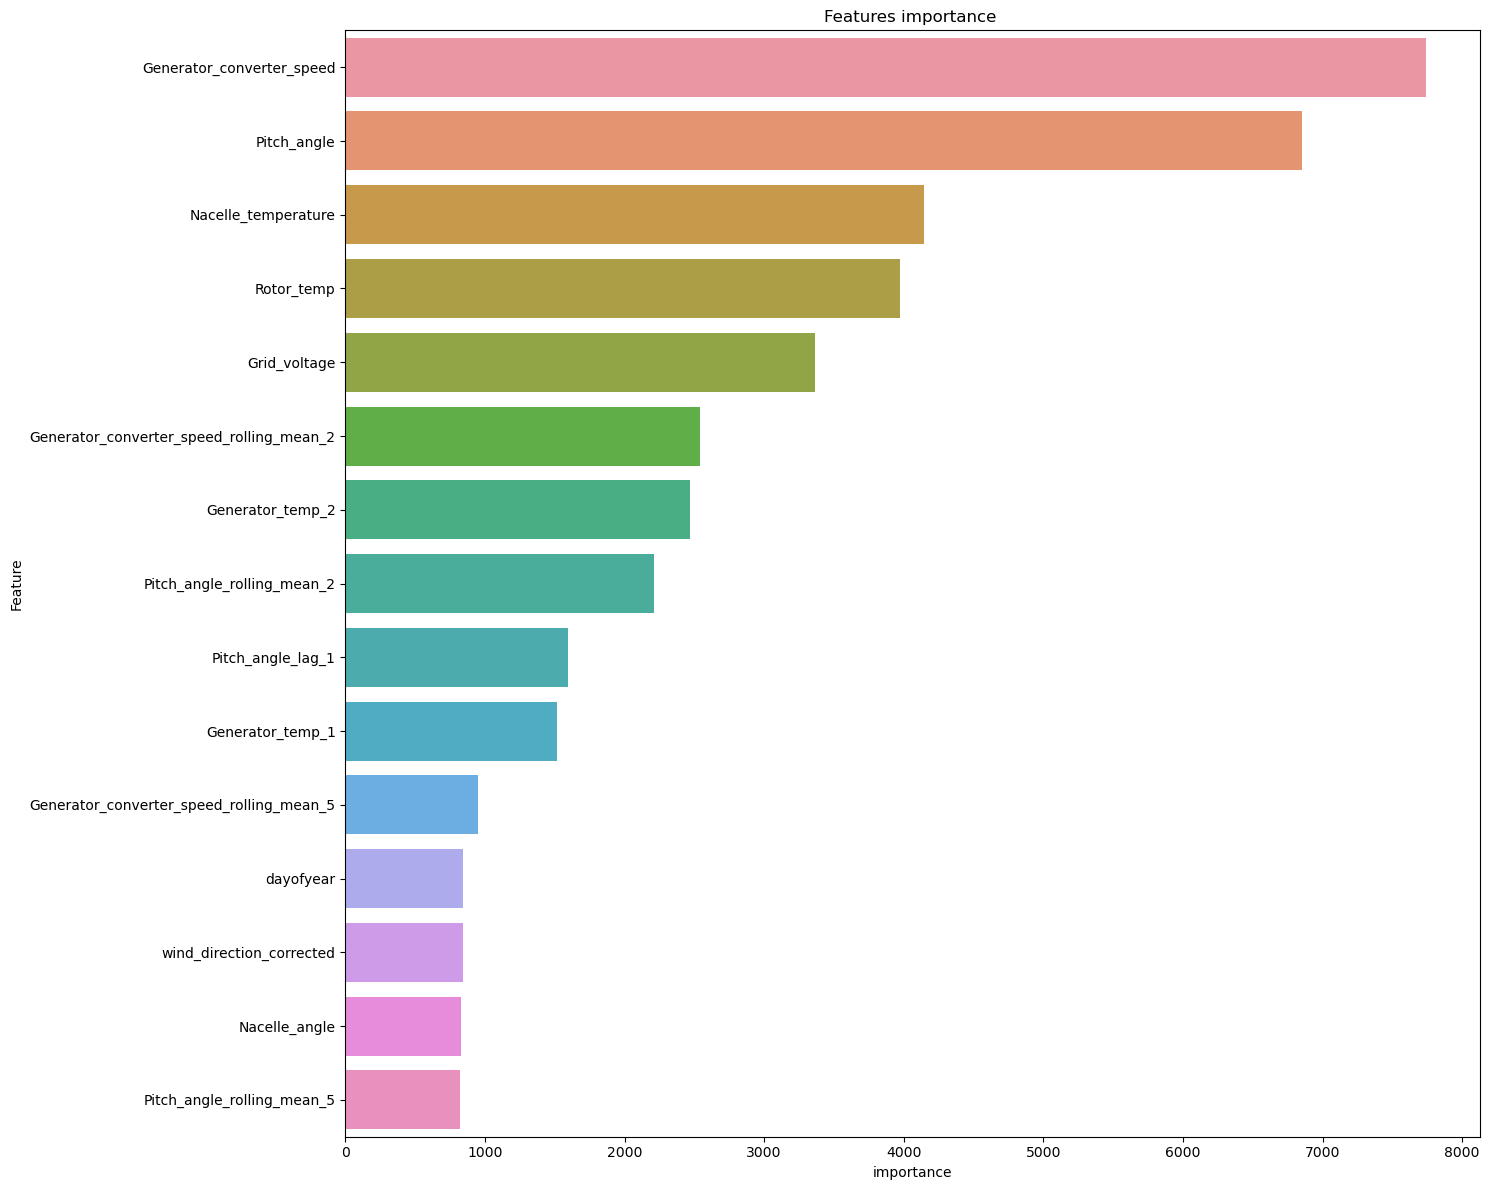

 MAE Val score = 216.5779
 MEDIAN AE Val score = 80.8126
 r2_score Val score =  0.1536
TRAINING IN FOLD :  4
[1]	valid_0's mape: 0.926261
Training until validation scores don't improve for 200 rounds
[2]	valid_0's mape: 0.919756
[3]	valid_0's mape: 0.913563
[4]	valid_0's mape: 0.907431
[5]	valid_0's mape: 0.901681
[6]	valid_0's mape: 0.895589
[7]	valid_0's mape: 0.889818
[8]	valid_0's mape: 0.883908
[9]	valid_0's mape: 0.878117
[10]	valid_0's mape: 0.872527
[11]	valid_0's mape: 0.866771
[12]	valid_0's mape: 0.8611
[13]	valid_0's mape: 0.855698
[14]	valid_0's mape: 0.850125
[15]	valid_0's mape: 0.844634
[16]	valid_0's mape: 0.839162
[17]	valid_0's mape: 0.833821
[18]	valid_0's mape: 0.828387
[19]	valid_0's mape: 0.823092
[20]	valid_0's mape: 0.817908
[21]	valid_0's mape: 0.812661
[22]	valid_0's mape: 0.807604
[23]	valid_0's mape: 0.80238
[24]	valid_0's mape: 0.797328
[25]	valid_0's mape: 0.792449
[26]	valid_0's mape: 0.787535
[27]	valid_0's mape: 0.782431
[28]	valid_0's mape: 0.777566
[

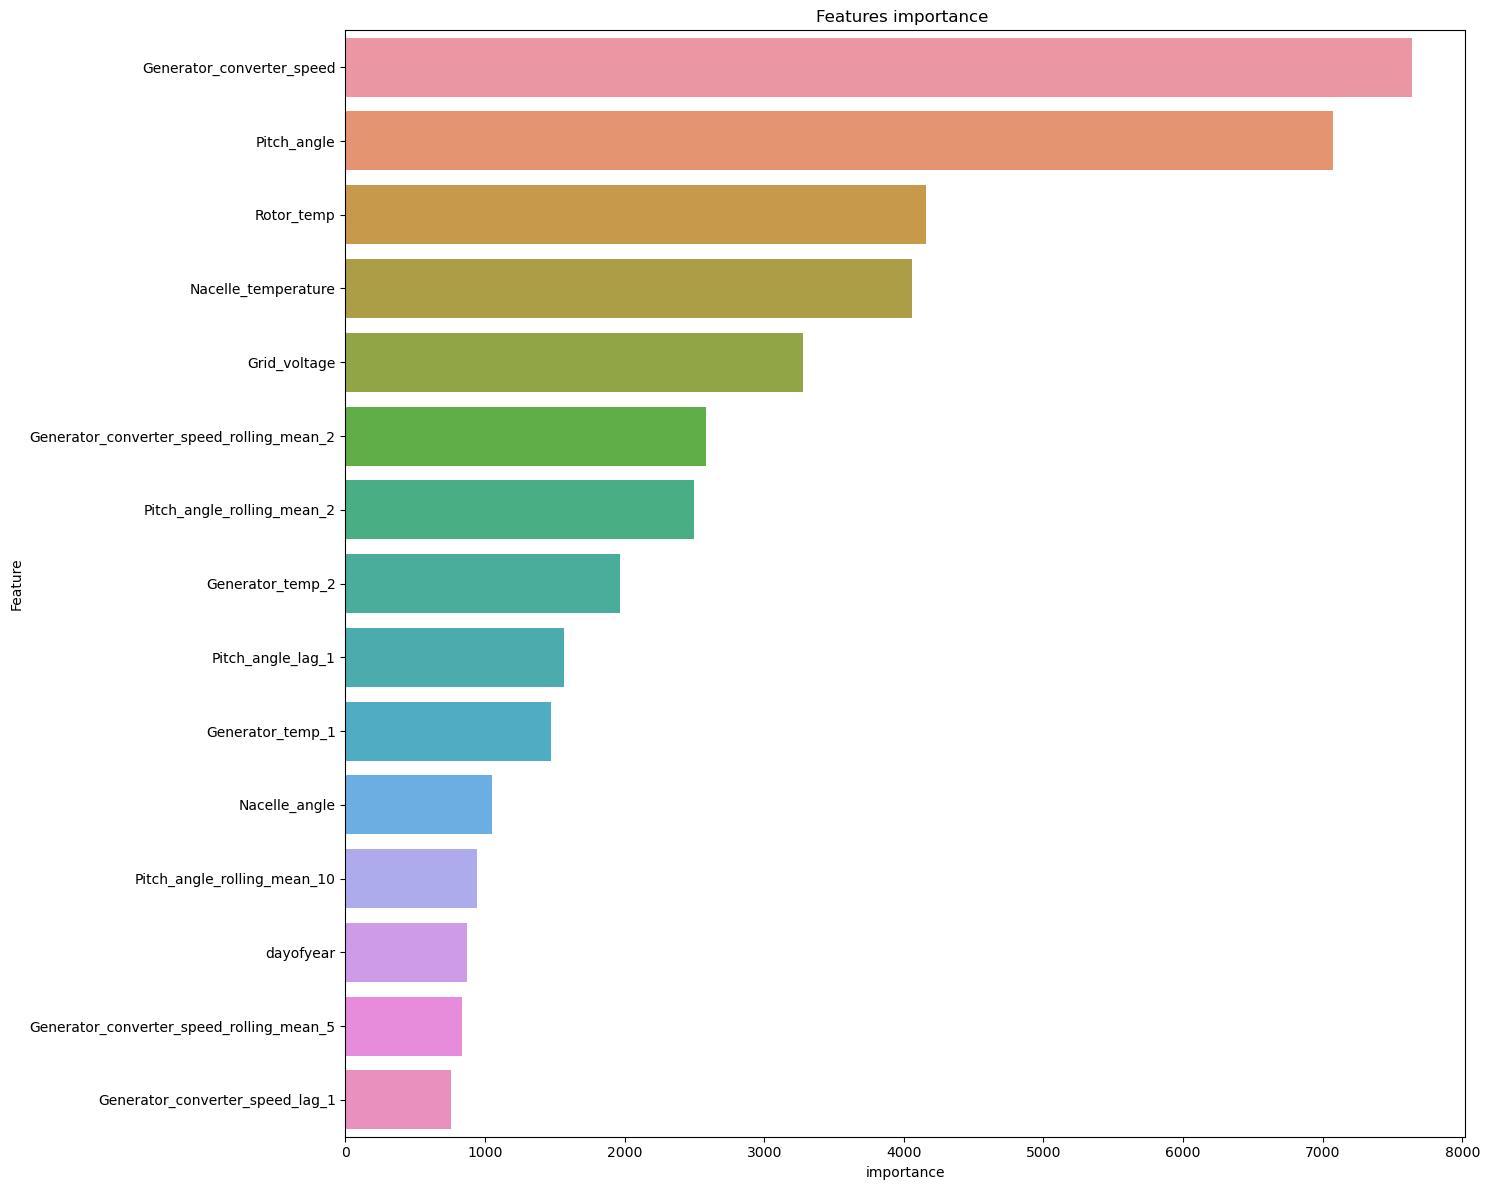

 MAE Val score = 258.6248
 MEDIAN AE Val score = 114.5842
 r2_score Val score =  0.1572


In [131]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score
from sklearn.model_selection import KFold

# Define the number of folds
num_folds = 5
kf = KFold(n_splits=num_folds)


valid_scores = []
models = []
y_preds = []

for fold, (train_index, valid_index) in enumerate(kf.split(df_train)):
    print("TRAINING IN FOLD : ", fold)
    X_train, y_train = df_train.iloc[train_index].drop(columns="Power"), df_train.Power[train_index]
    X_valid, y_valid = df_train.iloc[valid_index].drop(columns="Power"), df_train.Power[valid_index]

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

    model = lgb.train(params, train_set=lgb_train, valid_sets=lgb_eval,
                      early_stopping_rounds=200)

    y_pred = model.predict(X_valid, num_iteration=model.best_iteration)
    valid_score = mean_absolute_error(y_valid, y_pred)
    valid_scores.append(valid_score)
    models.append(model)
    y_preds.append(model.predict(df_test, num_iteration=model.best_iteration))

    lgbm_features_importance(model,df_test.columns)

    print(f' MAE Val score = {valid_score:.4f}')
    print(f' MEDIAN AE Val score = {median_absolute_error(y_valid, y_pred):.4f}')
    print(f' r2_score Val score =  {r2_score(y_valid, y_pred):.4f}')

In [ ]:
print(f' valid_scores = {np.median(valid_scores)}')

In [ ]:
_y_pred = []
for model in models:
    _y_pred.append(model.predict(df_test, num_iteration=model.best_iteration))
_y_pred = np.array(_y_pred)

In [ ]:
y_pred = _y_pred.mean(axis=0)

In [ ]:
y_pred = pd.DataFrame(y_pred, columns=["y_pred"])
y_pred.to_csv("y_pred.csv", index=False)

## MODELS TEST:

In [19]:
from sklearn.model_selection import train_test_split
X_train , X_test, y_train, y_test = train_test_split(df_train.drop(columns="Power"), df_train[['Power']], train_size=0.7, random_state=0)

In [21]:
X_train.shape, y_train.shape

((86464, 30), (86464, 1))

In [23]:
import os
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
from sklearn.model_selection import train_test_split

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print("Running on TPU ", tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
elif tf.config.list_physical_devices("GPU"):
    strategy = tf.distribute.OneDeviceStrategy("GPU:0")
    print("Running on GPU ")
else:
    strategy = tf.distribute.OneDeviceStrategy("CPU:0")
    print("Running on CPU ")


Running on GPU 


In [24]:
def create_model(name, input_shape=None):
    with strategy.scope():
        if name == "LSTM":
            model = Sequential([LSTM(128, input_shape=input_shape), Dense(1)])
        elif name == "RNN":
            model = Sequential(
                [
                    SimpleRNN(128, input_shape=input_shape, return_sequences=True),
                    Dropout(0.2),
                    SimpleRNN(64, return_sequences=True),
                    Dropout(0.2),
                    SimpleRNN(32),
                    Dropout(0.2),
                    Dense(64, activation="relu"),
                    Dropout(0.2),
                    Dense(1),
                ]
            )
        elif name == "Dropout MLP":
            model = Sequential(
                [
                    Dense(128, input_dim=input_shape[0], activation="relu"),
                    Dropout(0.5),
                    Dense(1),
                ]
            )
        elif name == "Batch Normalization MLP":
            model = Sequential(
                [
                    Dense(128, input_dim=input_shape[0], activation="relu"),
                    BatchNormalization(),
                    Dense(1),
                ]
            )
        elif name == "L2 Regularized MLP":
            model = Sequential(
                [
                    Dense(
                        128,
                        input_dim=input_shape[0],
                        activation="relu",
                        kernel_regularizer=l2(0.01),
                    ),
                    Dense(1),
                ]
            )
        elif name == "Conv1D MLP":
            model = Sequential(
                [
                    Conv1D(
                        32, kernel_size=3, activation="relu", input_shape=input_shape
                    ),
                    Flatten(),
                    Dense(1),
                ]
            )
        elif name == "Global Max Pooling 1D MLP":
            model = Sequential(
                [
                    Conv1D(
                        32, kernel_size=3, activation="relu", input_shape=input_shape
                    ),
                    GlobalMaxPooling1D(),
                    Dense(1),
                ]
            )
        elif name == "Global Average Pooling 1D MLP":
            model = Sequential(
                [
                    Conv1D(
                        32, kernel_size=3, activation="relu", input_shape=input_shape
                    ),
                    GlobalAveragePooling1D(),
                    Dense(1),
                ]
            )
        elif name == "Bidirectional LSTM":
            model = Sequential(
                [Bidirectional(LSTM(128, input_shape=input_shape)), Dense(1)]
            )
        elif name == "GRU":
            model = Sequential([GRU(128, input_shape=input_shape), Dense(1)])
        elif name == "Adam MLP":
            model = Sequential(
                [Dense(128, input_dim=input_shape[0], activation="relu"), Dense(1)]
            )
        else:
            raise ValueError(f"Unknown model name: {name}")
    return model


In [ ]:
models = {
    "Linear Regression": LinearRegression(random_state=42),
    "Ridge": Ridge(random_state=42),
    "Lasso": Lasso(random_state=42),
    "Elastic Net": ElasticNet(random_state=42),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "AdaBoost": AdaBoostRegressor(random_state=42),
    "KNN": KNeighborsRegressor(random_state=42),
    "Gaussian Process": GaussianProcessRegressor(random_state=42),
    "Isotonic Regression": IsotonicRegression(random_state=42),
    "Linear SVR": LinearSVR(random_state=42),
    "Extra Trees": ExtraTreesRegressor(random_state=42),
    "CatBoost": CatBoostRegressor(random_state=42),
    "LGBM": LGBMRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42),
    "MLP": MLPRegressor(random_state=42),
    "LSTM": "LSTM",
    "RNN": "RNN",
    "Dropout MLP": "Dropout MLP",
    "Batch Normalization MLP": "Batch Normalization MLP",
    "L2 Regularized MLP": "L2 Regularized MLP",
    "Conv1D MLP": "Conv1D MLP",
    "Global Max Pooling 1D MLP": "Global Max Pooling 1D MLP",
    "Global Average Pooling 1D MLP": "Global Average Pooling 1D MLP",
    "Bidirectional LSTM": "Bidirectional LSTM",
    "GRU": "GRU",
    "Adam MLP": "Adam MLP",
    "NuSVR": NuSVR(random_state=42),
    "SVR": SVR(random_state=42),
}


In [25]:
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.svm import NuSVR, SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.isotonic import IsotonicRegression
from sklearn.svm import LinearSVR
from tensorflow.keras.layers import Dropout, BatchNormalization, Conv1D, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import GlobalMaxPooling1D, GlobalAveragePooling1D, Bidirectional, GRU
from tensorflow.keras.optimizers import Adam


In [26]:
from sklearn.metrics import mean_absolute_error, median_absolute_error

def test_regression_models(models, X_train, X_test, y_train, y_test, optimizer='adam', loss='mse'):
    _models_ = []
    results = {"Model": [], "R2": [], "MSE": [], "RMSE": [], "MAE": [], "MedAE": []}
    histories = {}

    for name, model in tqdm(models.items()):
        try:
            if name in {
                "LSTM",
                "RNN",
                "Dropout MLP",
                "Batch Normalization MLP",
                "L2 Regularized MLP",
                "Conv1D MLP",
                "Global Max Pooling 1D MLP",
                "Global Average Pooling 1D MLP",
                "Bidirectional LSTM",
                "GRU",
                "Adam MLP",
            }:
                input_shape = (
                    (X_train.shape[1], 1)
                    if "Conv1D" in name
                    or name in {"LSTM", "RNN", "Bidirectional LSTM", "GRU"}
                    else (X_train.shape[1],)
                )
                X_train_reshaped = X_train.values.reshape((X_train.shape[0],) + input_shape)
                X_test_reshaped = X_test.values.reshape((X_test.shape[0],) + input_shape)
                model = create_model(name, input_shape=input_shape)
                model.compile(optimizer=optimizer, loss=loss)
                history = model.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, verbose=0)
                y_pred = model.predict(X_test_reshaped)
                y_pred = y_pred.reshape((y_pred.shape[0],))
                histories[name] = history
            else:
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
            r2 = r2_score(y_test, y_pred)
            mse = mean_squared_error(y_test, y_pred)
            rmse = mean_squared_error(y_test, y_pred, squared=False)
            mae = mean_absolute_error(y_test, y_pred)
            medae = median_absolute_error(y_test, y_pred)
            results["Model"].append(name)
            results["R2"].append(r2)
            results["MSE"].append(mse)
            results["RMSE"].append(rmse)
            results["MAE"].append(mae)
            results["MedAE"].append(medae)
            _models_.append({name: model})
        
        except Exception as e:
            print(f"Error occurred while training {name}: {e}")
            continue

    return pd.DataFrame(results), _models_, histories


In [27]:
import matplotlib.pyplot as plt

def plot_history(histories, metric):
    plt.figure(figsize=(12, 8))

    for name, history in histories.items():
        plt.plot(history.history[metric], label=name)

    plt.title(f'Training {metric}')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.show()


In [28]:
little_models = {"LSTM": "LSTM",
    "RNN": "RNN",
    "Dropout MLP": "Dropout MLP",
    "Batch Normalization MLP": "Batch Normalization MLP",
    "L2 Regularized MLP": "L2 Regularized MLP",
    "Conv1D MLP": "Conv1D MLP",
    "Global Max Pooling 1D MLP": "Global Max Pooling 1D MLP",
    "Global Average Pooling 1D MLP": "Global Average Pooling 1D MLP",
    "Bidirectional LSTM": "Bidirectional LSTM",
    "GRU": "GRU",
    "Adam MLP": "Adam MLP"}

In [ ]:
results, _models_, histories = test_regression_models(little_models, X_train, X_test, y_train, y_test, optimizer='adam', loss='mse')

  0%|          | 0/11 [00:00<?, ?it/s]

1158/1158 [==============================] - 3s 2ms/step


  9%|▉         | 1/11 [09:42<1:37:07, 582.79s/it]

1158/1158 [==============================] - 5s 4ms/step


 18%|█▊        | 2/11 [27:57<2:12:36, 884.07s/it]

In [166]:
results

,Model,R2,MSE,RMSE
0,CatBoost,0.906277,16119.102731,126.961028
1,LGBM,0.887505,19347.749020,139.096186
2,XGBoost,0.897539,17622.043940,132.748047
3,MLP,0.802738,33926.600840,184.191750


In [ ]:
plot_history(histories, 'loss')


In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Define base models
models = [
    ('catboost', CatBoostRegressor(random_state=42)),
    ('lgbm', LGBMRegressor(random_state=42)),
    ('xgboost', XGBRegressor(random_state=42)),
    #('nusvr', NuSVR()),
    #('svr', SVR()),
    ('mlp', MLPRegressor(random_state=42))
]

# Define meta model
meta_model = LinearRegression()

# Define stacking regressor
stacking_regressor = StackingRegressor(
    estimators=models,
    final_estimator=meta_model,
    cv=5
)

# Train stacking regressor
stacking_regressor.fit(X_train, y_train)

# Make predictions
y_pred = stacking_regressor.predict(X_test)

# Evaluate model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'R2: {r2:.2f}')
